# Tutorial 4: What lies beneath the surface?

## Interacting with diffuse light attenuation coefficients.

We often think of remote sensing products as largely representative of near-surface values. For the most part, this is true. With ocean color, we're essentially looking at an integrated signal of light emerging from the ocean. The differential depths at which light disappears is a function of how turbid the water is, which, in turn, impacts how much an individual wavelength of light contributes to the remote sensing refelctance that we see from space. Let's follow the story of a little photon of light with a bit more detail.

First, let's call "light" out by it's prefered terminology in this context - spectral downwelling irradiance just below the sea surface, $E_{s}^{-}({\lambda})$, a term that represents the amount of light at each wavelength that has hit the surface of the ocean and crossed over the air-sea barrier. From here, $E_{s}^{-}({\lambda})$ is attenuated (i.e., disappeared) exponentially with depth ($z$). PACE now provides the slope of this exponential decay function, known as the diffuse light attenuation coefficient, $K_{d}({\lambda})$, for 19 individual wavelengths. Thus, at any given depth of the ocean, we can determine the spectral downwelling irradiance, $E_{d}({\lambda},z)$, as follows:

$E_{d}({\lambda},z) = E_{s}^{-}({\lambda})*exp^{-Kd*z}$

If we are supplied a standard reference $E_{s}^{-}({\lambda})$ spectrum, a $K_{d}({\lambda})$ value from PACE, and a depth of our choice, we can solve for $E_{d}({\lambda},z)$ and figure out how much and what kind of light is available at any given depth, anywhere in the ocean. In other words, a 3D product! Well, 4D I guess, if we consider latitude, longitiude, wavelengths, and depth. If this is a bit fuzzy, not to worry, we'll illustrate this concept a bit more in the following exercises.

By the end of this tutorial, you will have:

> 1. Created a global map of the downwelling light attenuation coefficient product from PACE
> 2. Created a depth profile showing the variation of spectral downwelling irradiance 
> 3. Created a spectral plot of downwelling irradiance showing the changes in light quality with depth
> 4. Created a pretty cross-section plot illustrating the difference in light penetration for two different areas

## *Are you ready?*

## A standard, run-of-the-mill rainbow

Where do bad rainbows go? (They go to Prism) They get a light sentence though, it's only so they can have time to reflect...

...

...

Right. First thing, we need a reference spectrum. As mentioned above, this is spectral downwelling irradiance just below the sea surface, $E_{s}^{-}({\lambda})$. If you're interested in the details, this was calculated from the ASTM G173-03 Reference Spectra Derived from SMARTS v. 2.9.2, additionally corrected for an average sun angle for satellites, diffuse contributions, and crossing the air-sea boundary.

In [2]:
import pandas as pd

# Load the CSV file
df_es = pd.read_csv('Es_spectrum.csv')
wave_Es = df_es['wave'].values
Es = df_es['Es'].values

Just in case you like to see what this looks like so it's not some abstract concept, let's take a quick look. This is a quantified representation of the sun's intensity of light at different wavelengths, after passing through the atmosphere and sitting at the very tip top surface layer of ocean water. We're getting a little fancy with the rainbow colors, but it helps illustrate the point. Refer to the commented out portion for a simpler representation. 

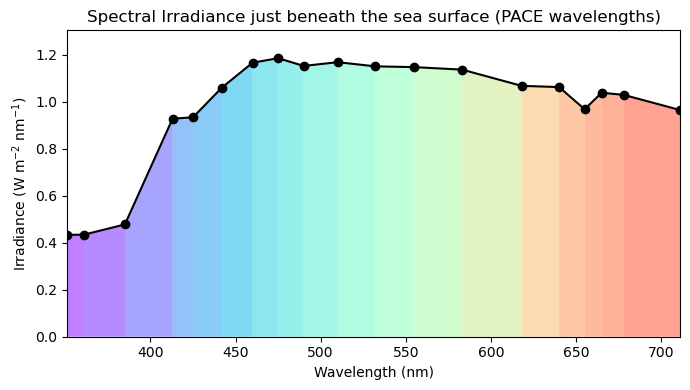

In [3]:
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import numpy as np

# Simple line plot
#plt.plot(wave_Es, Es, 'o-', label='Es') 
#plt.xlabel('Wavelength (nm)')
#plt.ylabel('Irradiance (W m$^{-2}$ nm$^{-1}$)')
#plt.title('Spectral Irradiance just beneath the sea surface (PACE wavelengths)')
#plt.tight_layout()
#plt.show()

# Fancy plot with rainbows, because rainbows are rad
# Normalize wavelengths for colormap
norm = plt.Normalize(wave_Es.min(), wave_Es.max())
colors = plt.cm.rainbow(norm(wave_Es[:-1]))  # one color per segment

# Build segments for PolyCollection
verts = []
for i in range(len(wave_Es) - 1):
    verts.append([
        (wave_Es[i], 0), (wave_Es[i], Es[i]),
        (wave_Es[i+1], Es[i+1]), (wave_Es[i+1], 0)
    ])

poly = PolyCollection(verts, facecolors=colors, alpha=0.5)

# Plot
fig, ax = plt.subplots(figsize=(7, 4))
ax.add_collection(poly)
ax.plot(wave_Es, Es, 'k-o', label='Es')  # line on top for visibility

ax.set_xlim(wave_Es.min(), wave_Es.max())
ax.set_ylim(0, max(Es) * 1.1)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Irradiance (W m$^{-2}$ nm$^{-1}$)')
ax.set_title('Spectral Irradiance just beneath the sea surface (PACE wavelengths)')
plt.tight_layout()
plt.show()

## Lock and load the PACE data

In [4]:
import earthaccess
import xarray as xr
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

Enter your Earthdata Login username:  ryan.vandermeulen@noaa.gov
Enter your Earthdata password:  ········


In [5]:
results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_KD",
    temporal = ("2024-09-01", "2024-09-30"),
    granule_name="*.MO.*.0p1deg.*"
)

There are fancy ways of finding the "short_name" above, but if you're not familiar with them and in a hurry, find your dataset here: https://www.earthdata.nasa.gov/data/catalog?keyword=PACE%20OCI&platforms_h[0][basis]=Space-based%20Platforms&science_keywords_h[0][topic]=Oceans

In [6]:
# Create a fileset
fileset = earthaccess.open(results);

import h5netcdf
with h5netcdf.File(fileset[0]) as file:
    groups = list(file)
groups

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['processing_control', 'wavelength', 'Kd', 'lat', 'lon', 'palette']

In [7]:
# ---- Load Libraries ----
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from scipy.integrate import trapezoid

# Load relevant datasets
dataset = xr.open_dataset(fileset[0])

# Assign core variables
latitude = dataset["lat"]
longitude = dataset["lon"]
Kd = dataset["Kd"]
wavelengths = dataset["wavelength"]

## The world is at your fingertips

Let's start by choosing a single wavelength, and making a map of Kd from PACE. 490 nm is a "heritage" color band that has been used as a standard for multispectral satellite missions.

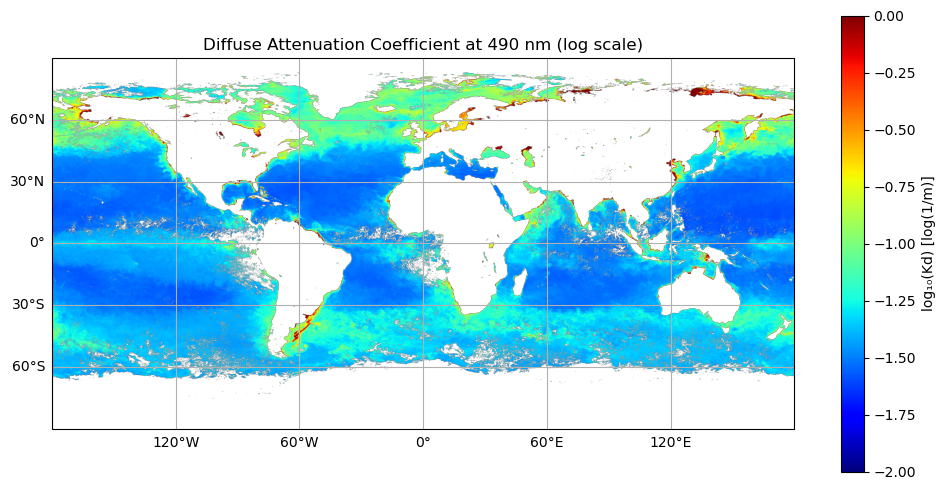

In [8]:
# Clean the data: mask invalid or non-positive Kd values
Kd_490 = Kd.sel(wavelength=490.0, method="nearest")
Kd_490_clean = Kd_490.where(Kd_490 > 0)  # xarray masking

# Convert to log scale
Kd_log = np.log10(Kd_490_clean)
Kd_log = np.flipud(Kd_log)

# Plot with imshow
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.gridlines(draw_labels={"bottom": "x", "left": "y"})
plt.imshow(
    Kd_log,
    origin='lower',
    cmap='jet',
    extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
    vmin=-2, vmax=0  # e.g., log10(0.01) to log10(1.0)
)
plt.colorbar(label='log₁₀(Kd) [log(1/m)]')
plt.title('Diffuse Attenuation Coefficient at 490 nm (log scale)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

Lower Kd values = lower rate of light attenuation = light goes deeper into the water

Higher Kd values = more rapid attenutation of light = light doesn't go as deep

## Pick a point, any point

You can change the coordiantes below if you'd like, but what this is going to do is extract the Kd data at all wavelengths for that specified point on the map.

In [9]:
# target coordinates
target_lat = 30.0
target_lon = -60.0

# get lat/lon arrays
lat_vals = latitude.values  # shape (1800,)
lon_vals = longitude.values  # shape (3600,)

# create 2D meshgrid of coordinate distances
lat_grid, lon_grid = np.meshgrid(lat_vals, lon_vals, indexing='ij')

# calculate distance from target point
dist = np.abs(lat_grid - target_lat) + np.abs(lon_grid - target_lon)  

# find the indices of the minimum distance
i, j = np.unravel_index(np.argmin(dist), dist.shape)

Kd_pixel = Kd.isel(lat=i, lon=j)  # shape: (wavelength,)
wavelengths_vals = Kd_pixel['wavelength'].values
Kd_vals = Kd_pixel.values

We're then going to choose three wavelengths, one red (678 nm), one green (555 nm), one blue-ish (490 nm). Using the reference irradiance data we imported earlier, we're going to use those $K_{d}({\lambda})$ terms from PACE to propagate the light ($E_{d}({\lambda},z)$) downward. Then we'll see what that looks like in a profile plot. 

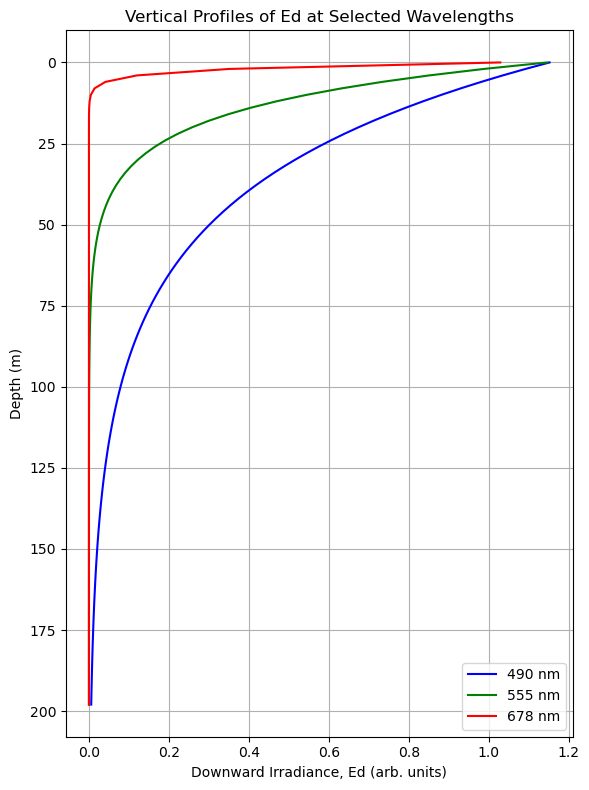

In [10]:
# Find indices of desired wavelengths (or nearest)
idx_490 = np.abs(wavelengths_vals - 490).argmin()
idx_555 = np.abs(wavelengths_vals - 555).argmin()
idx_678 = np.abs(wavelengths_vals - 678).argmin()

# Extract Kd and Es for each wavelength
Kd_490, Kd_555, Kd_678 = Kd_vals[idx_490], Kd_vals[idx_555], Kd_vals[idx_678]
Ed_0_490, Ed_0_555, Ed_0_678 = Es[idx_490], Es[idx_555], Es[idx_678]

# Create depth array (e.g., 0 to 200 m in 2 m steps)
depths = np.arange(0, 200, 2)

# Compute Ed profiles
Ed_490 = Ed_0_490 * np.exp(-Kd_490 * depths)
Ed_555 = Ed_0_555 * np.exp(-Kd_555 * depths)
Ed_678 = Ed_0_678 * np.exp(-Kd_678 * depths)

# Plot
plt.figure(figsize=(6, 8))
plt.plot(Ed_490, depths, '-b', label='490 nm')
plt.plot(Ed_555, depths, '-g', label='555 nm')
plt.plot(Ed_678, depths, '-r', label='678 nm')

plt.gca().invert_yaxis()
plt.xlabel("Downward Irradiance, Ed (arb. units)")
plt.ylabel("Depth (m)")
plt.title("Vertical Profiles of Ed at Selected Wavelengths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

What we can see here is that attenuation rates are not very steep for blue light, meaning blue light goes pretty far into the water column. This is a good indicator that we're dealing with open ocean waters. An honerable mention to green light, of course, who made it down about 75 meters before disappearing. Way to go green, we're all rooting for you. Then there's red. What are you doing red? Well, it turns out that even in the absence of a lot of absorbing and scattering particles, the very nature of pure water means it is going to absorb red light pretty quickly, so it left the party a bit early. 

## Let's look at this another way

Since we've got all this cool extra information from PACE, let's go ahead and make sure we get use out of those additional wavelengths. In the case below, we'll look at the whole spectrum of downwelling irradiance that we've calculated, and examine how it changes over some nominal depth intervals. 

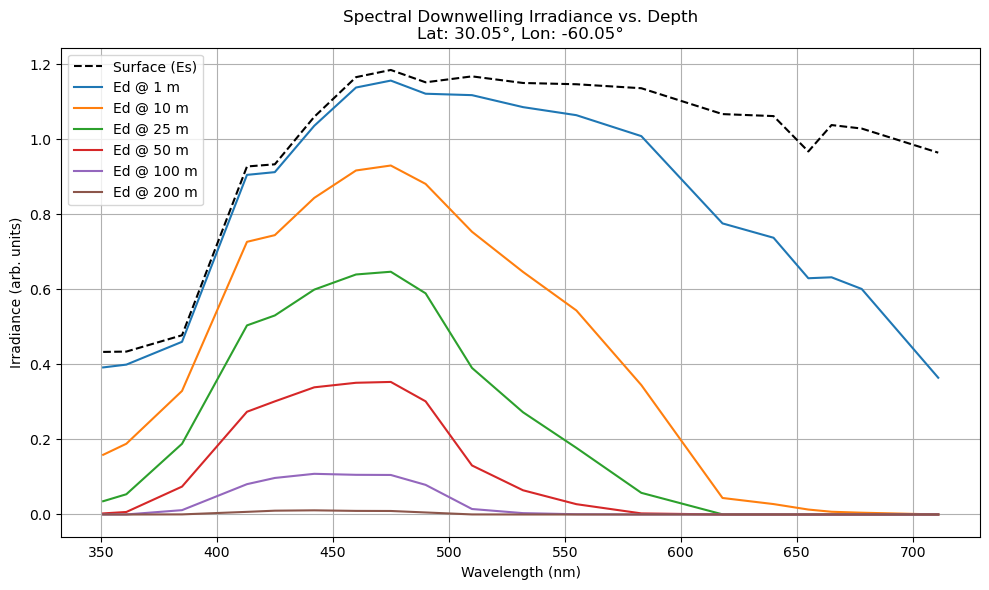

In [22]:
depths = [1, 10, 25, 50, 100, 200]
attenuated_spectra = {}

for z in depths:
    attenuated_spectra[z] = Es * np.exp(-Kd_vals * z)

plt.figure(figsize=(10, 6))

# Plot Es (surface spectrum)
plt.plot(wavelengths_vals, Es, 'k--', label='Surface (Es)')

# Plot each Ed(z)
for z in depths:
    plt.plot(wavelengths_vals, attenuated_spectra[z], label=f'Ed @ {z} m')

lat_val = latitude[i].item()
lon_val = longitude[j].item()

plt.xlabel("Wavelength (nm)")
plt.ylabel("Irradiance (arb. units)")
plt.title(f"Spectral Downwelling Irradiance vs. Depth\nLat: {lat_val:.2f}°, Lon: {lon_val:.2f}°")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

You can clearly see the anti-social red light absolutely refusing to joint its friends into the deep. As such, the deeper you go, other wavelengths of light eventually attenuatre as well, creating a dominance of blue light into the depths. This is the case for the open ocean. For funzies, feel free to go back and put in some different coordiantes, perhaps closer to the coast. A very different pattern will emerge here, as we'll ilustrate below.  

## Let's paint the town rainbow!

Let's try a more integrated approach, so we can really see what is happening to the light with depth. We're going to extract two points - our open ocean example we used above, and then a point near the productive waters in the Patagonian shelf upwelling system. Doing a lot of the things we did earlier in the tutorial, we're going to restructure the data a tiny bit, so we get a higher (depth) resolution profile. In this instance, we'll generate an $E_{d}({\lambda},z)$ spectrum every 2 meters, over 100 meters of depth. After stacking this, we'll plot it more like a cross-section of light, illustrating the 4D nature of the PACE $K_{d}({\lambda})$ products.

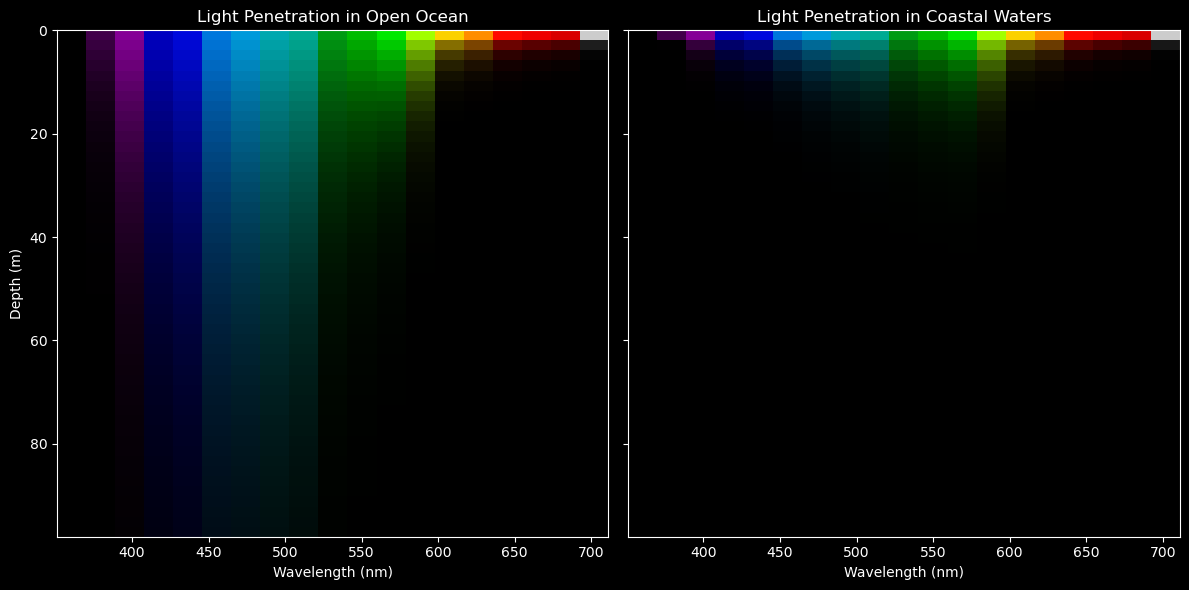

In [42]:
# open ocean coordinates
target_lat_open = 30.0
target_lon_open = -60.0

# coastal coordinates
target_lat_coastal = -45.0
target_lon_coastal = -60.0

# calculate distance from target point
dist_open = np.abs(lat_grid - target_lat_open) + np.abs(lon_grid - target_lon_open) 
dist_coastal = np.abs(lat_grid - target_lat_coastal) + np.abs(lon_grid - target_lon_coastal)

# find the indices of the minimum distance
i, j = np.unravel_index(np.argmin(dist_open), dist_open.shape)
k, l = np.unravel_index(np.argmin(dist_coastal), dist_coastal.shape)

Kd_pixel_open = Kd.isel(lat=i, lon=j)  # shape: (wavelength,)
wavelengths_vals = Kd_pixel_open['wavelength'].values
Kd_vals_open = Kd_pixel_open.values
Kd_pixel_coastal = Kd.isel(lat=k, lon=l)  # shape: (wavelength,)
Kd_vals_coastal = Kd_pixel_coastal.values

depths = np.arange(0, 100, 2)

# Pre-allocate arrays for better performance and compatibility with plotting
attenuated_spectra_open = np.zeros((len(depths), len(wavelengths_vals)))
attenuated_spectra_coastal = np.zeros((len(depths), len(wavelengths_vals)))

for i, z in enumerate(depths):
    attenuated_spectra_open[i, :] = Es * np.exp(-Kd_vals_open * z)
    attenuated_spectra_coastal[i, :] = Es * np.exp(-Kd_vals_coastal * z)

#from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

# Normalize wavelengths to [0, 1] for colormap
norm = Normalize(vmin=wavelengths_vals.min(), vmax=wavelengths_vals.max())
rgb_colors = plt.colormaps['nipy_spectral'](norm(wavelengths_vals))[:, :3]

# Normalize Ed at surface for comparison
open_norm = attenuated_spectra_open / attenuated_spectra_open[0, :]
coastal_norm = attenuated_spectra_coastal / attenuated_spectra_coastal[0, :]

# Optional: Mask out low-light values for better contrast
open_norm[open_norm < 1e-3] = np.nan
coastal_norm[coastal_norm < 1e-3] = np.nan

# Function to create RGB image
def spectra_to_rgb(spectra, rgb_colors):
    return spectra[..., np.newaxis] * rgb_colors[np.newaxis, :, :]

# Generate RGB images
rgb_open = spectra_to_rgb(open_norm, rgb_colors)
rgb_coastal = spectra_to_rgb(coastal_norm, rgb_colors)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# We turned everything else black, so let's change the text to white
for ax in axs:
    ax.set_facecolor('black')
    ax.tick_params(colors='white')                     # Tick labels
    ax.xaxis.label.set_color('white')                  # X-axis label
    ax.yaxis.label.set_color('white')                  # Y-axis label
    ax.title.set_color('white')                        # Title text
    for spine in ax.spines.values():
        spine.set_edgecolor('white')                   # Axes spines

fig.patch.set_facecolor('black')        # Figure background
for ax in axs:
    ax.set_facecolor('black')           # Plot (axes) background

for ax, rgb_img, title in zip(axs, [rgb_open, rgb_coastal], ["Open Ocean", "Coastal Waters"]):
    ax.imshow(rgb_img, aspect='auto',
              extent=[wavelengths_vals.min(), wavelengths_vals.max(), depths.max(), depths.min()])
    ax.set_title(f"Light Penetration in {title}")
    ax.set_xlabel("Wavelength (nm)")

axs[0].set_ylabel("Depth (m)")
plt.tight_layout()
plt.show()


Notice how the blue light didn't go down very far in the "Coastal Waters"? The reason for this is because greedy little phytoplankton are preferentially absorbing this blue light to fuel photosynthesis. We think of algae as green plants, but what we're seeing here is that they appear inherently green to our eyes only becuase they are utilizng all the other wavelengths of light except for green! Other things can absorb blue light as well, like chromophoric dissolved organic matter and detritus, further changing the differential attenuation rates. Now, attenuation doesn't just mean absorption of light. Light is also being scattered, perhaps multiple times. Particles can scatter light back out of the water and prevent it from going deeper, which also contributes to attenuation. Depending on the size and shape of that particle, it may be that it helps the light scatter multiple times, thereby increasing it's chance of being absorbed on the way back up! While we're only seeing a surface reflectance value from space, it represents a complex series of physical processes with light and the environment beneath the surface. 

There you have it! Spectral light attenutation of downwelling irradiance. Now you have the ability to quantitatively characterize the subsurface light field for any depth across the entire ocean. Go PACE!